## Machine Learning and Deep Learning Final Exam
Eirik Sundsøy (176654), Caoimhe Gallahue (175890)

In [239]:
# Import Libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [184]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [231]:
df = pd.read_csv('/content/drive/MyDrive/ML Final/processed_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188639 entries, 0 to 188638
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ACRS Report Type        188639 non-null  object 
 1   Crash Date/Time         188639 non-null  object 
 2   Collision Type          188639 non-null  object 
 3   Weather                 188639 non-null  object 
 4   Surface Condition       188639 non-null  object 
 5   Light                   188639 non-null  object 
 6   Driver Substance Abuse  188639 non-null  object 
 7   Injury Severity         188639 non-null  object 
 8   Driver Distracted By    188639 non-null  object 
 9   Vehicle Damage Extent   188639 non-null  object 
 10  Vehicle Body Type       188639 non-null  object 
 11  Speed Limit             188639 non-null  int64  
 12  Vehicle Year            188639 non-null  int64  
 13  Vehicle Make            188639 non-null  object 
 14  Latitude            

In [232]:
df_timeseries = df.copy()
df_corr = df.copy()
df_mlp = df.copy()
df_log = df.copy()
df_xgb = df.copy()

In [187]:
# Encoding for Correlation Matrix
object_cols = df_corr.select_dtypes(include=['object']).columns

le = LabelEncoder()
for col in object_cols:
  if col != 'Crash Date/Time':
    df_corr[col] = le.fit_transform(df_corr[col])

df_corr['Crash Date/Time'] = pd.to_datetime(df_corr['Crash Date/Time'])

# Extract day of the week (0 = Monday, 6 = Sunday)
df_corr['DayOfWeek'] = df_corr['Crash Date/Time'].dt.dayofweek
# Extract month
df_corr['Month'] = df_corr['Crash Date/Time'].dt.month

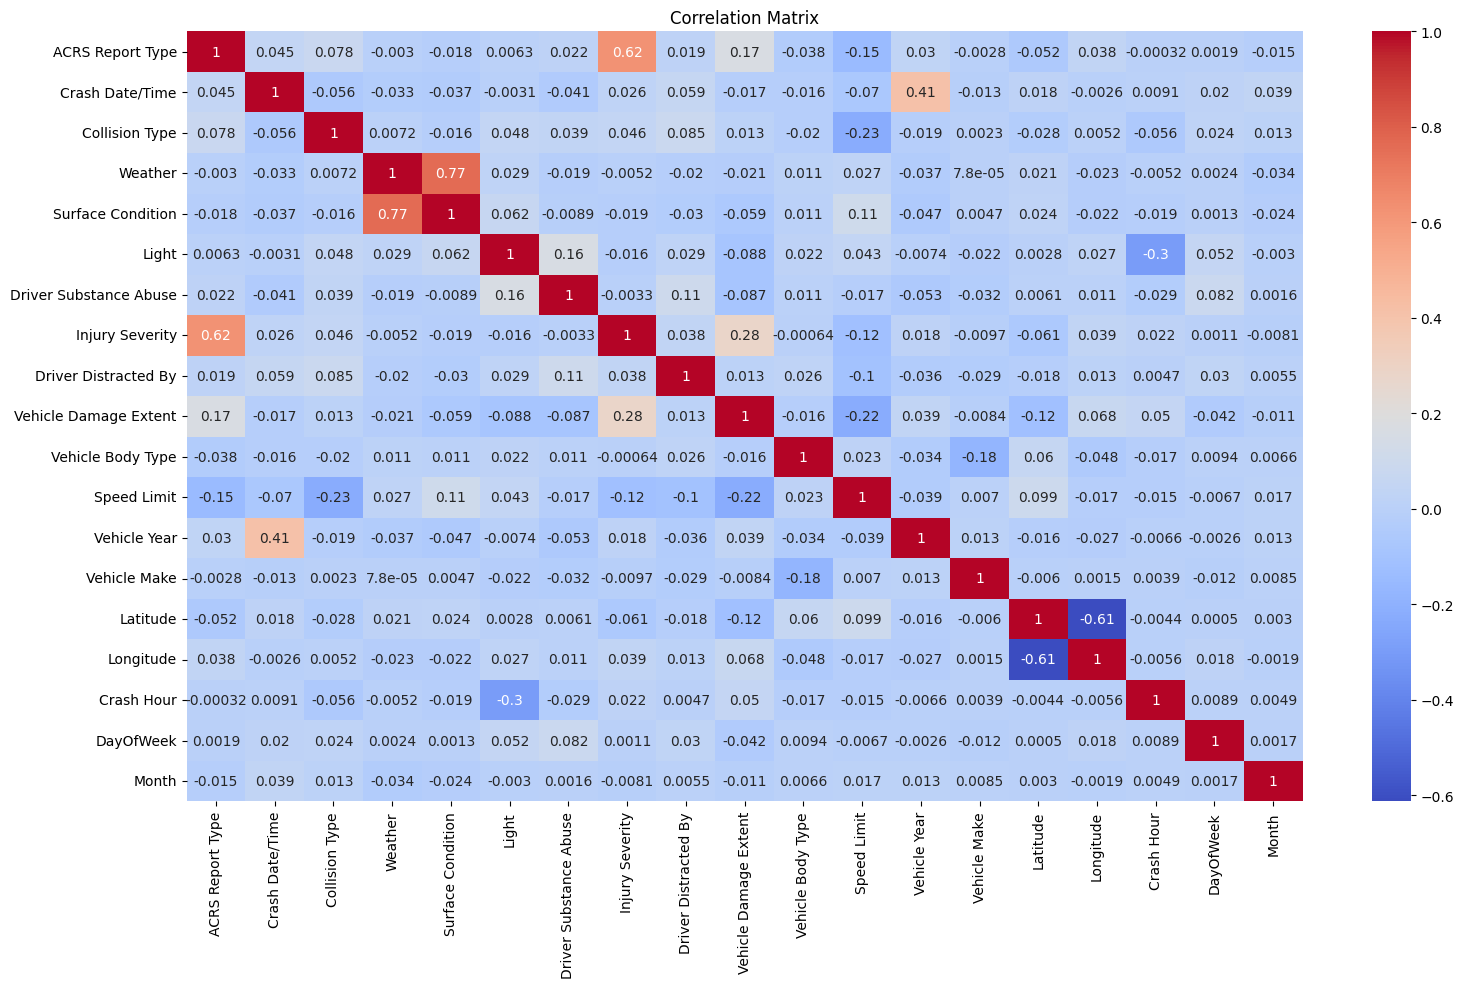

In [188]:
correlation_matrix = df_corr.corr()
plt.figure(figsize=(18, 10))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

###Timeseries

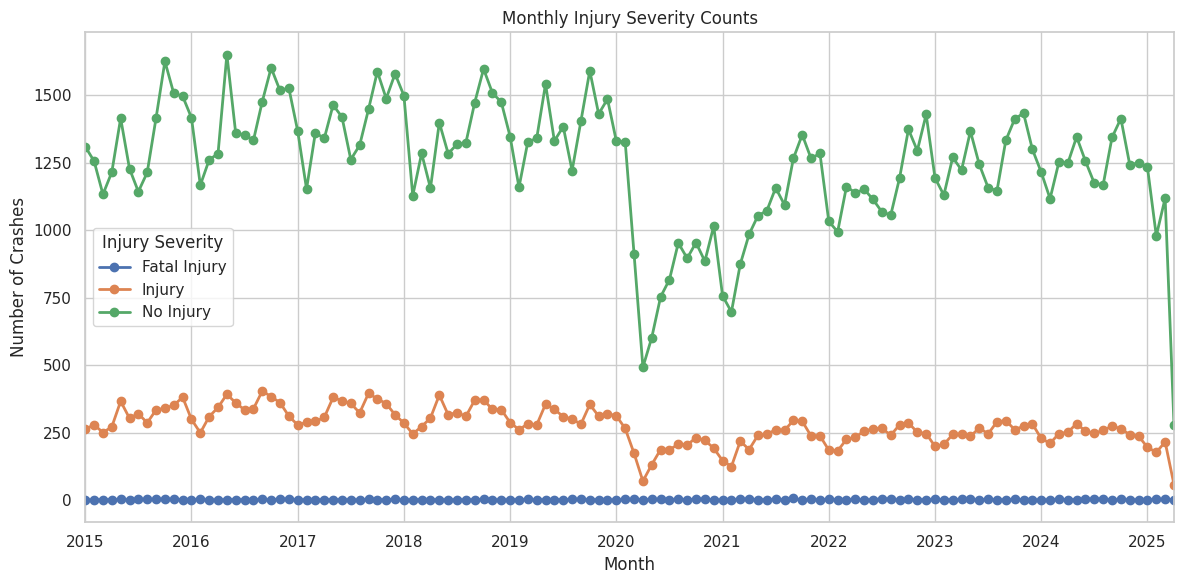

In [189]:
df_timeseries['Crash Date/Time'] = pd.to_datetime(df_timeseries['Crash Date/Time'])
df_timeseries['YearMonth'] = df_timeseries['Crash Date/Time'].dt.to_period('M')

monthly_counts = df_timeseries.groupby(['YearMonth', 'Injury Severity']).size().unstack(fill_value=0)
monthly_counts.index = monthly_counts.index.to_timestamp()

sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))

monthly_counts.plot(marker='o', linewidth=2, ax=plt.gca())
plt.title('Monthly Injury Severity Counts')
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.legend(title='Injury Severity')
plt.tight_layout()
plt.show()

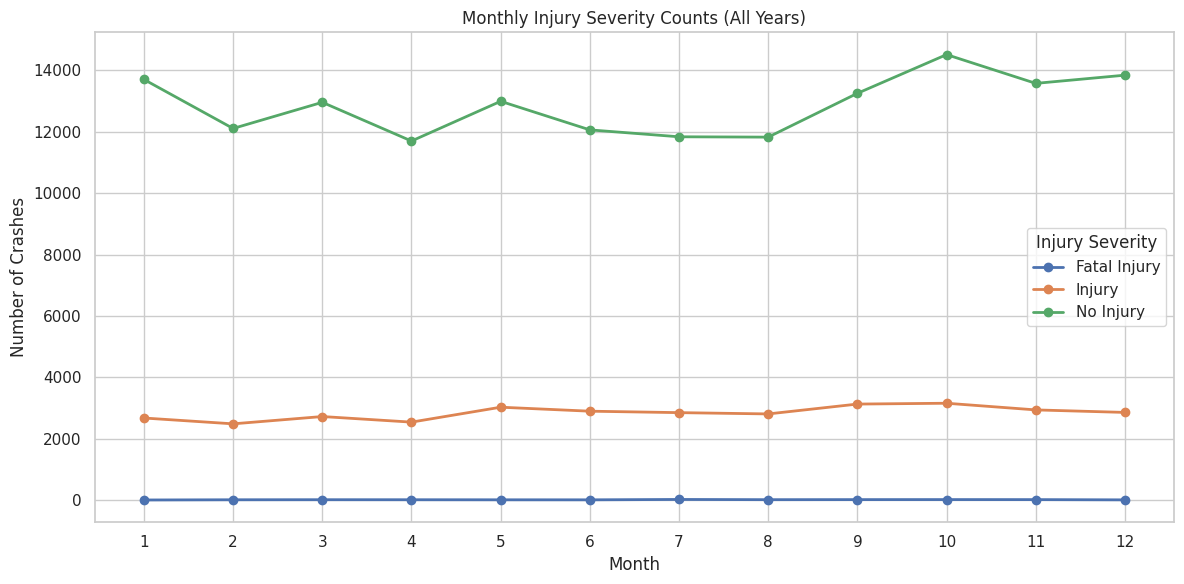

In [190]:
df_timeseries['Crash Date/Time'] = pd.to_datetime(df_timeseries['Crash Date/Time'])
df_timeseries['Month'] = df_timeseries['Crash Date/Time'].dt.month  # Extract month only

monthly_counts = df_timeseries.groupby(['Month', 'Injury Severity']).size().unstack(fill_value=0)

# Reset index for plotting (months as x-axis)
monthly_counts = monthly_counts.reset_index()

sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))

# Iterate through injury severity levels and plot
for severity in monthly_counts.columns[1:]:  # Skip 'Month' column
    plt.plot(monthly_counts['Month'], monthly_counts[severity], marker='o', linewidth=2, label=severity)

plt.title('Monthly Injury Severity Counts (All Years)')
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.xticks(range(1, 13))  # Set x-axis ticks for each month
plt.legend(title='Injury Severity')
plt.tight_layout()
plt.show()

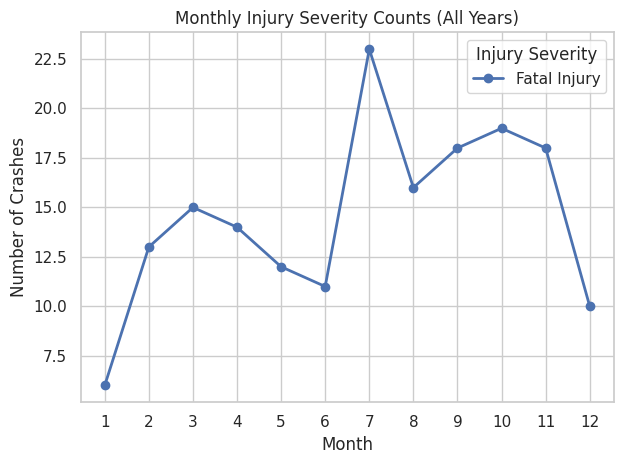

In [191]:
plt.plot(monthly_counts['Month'], monthly_counts['Fatal Injury'], marker='o', linewidth=2, label='Fatal Injury')

plt.title('Monthly Injury Severity Counts (All Years)')
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.xticks(range(1, 13))  # Set x-axis ticks for each month
plt.legend(title='Injury Severity')
plt.tight_layout()
plt.show()

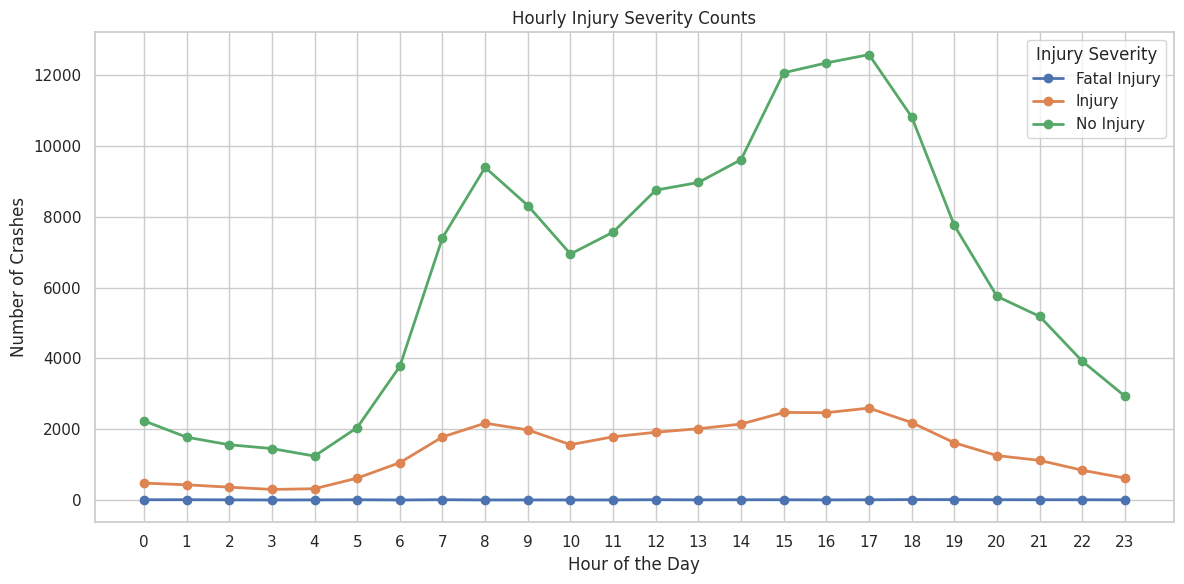

In [192]:
df_timeseries['Crash Date/Time'] = pd.to_datetime(df_timeseries['Crash Date/Time'])
df_timeseries['Hour'] = df_timeseries['Crash Date/Time'].dt.hour

hourly_counts = df_timeseries.groupby(['Hour', 'Injury Severity']).size().unstack(fill_value=0)

sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))

# Iterate through injury severity levels and plot
for severity in hourly_counts.columns:
    plt.plot(hourly_counts.index, hourly_counts[severity], marker='o', linewidth=2, label=severity)

plt.title('Hourly Injury Severity Counts')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crashes')
plt.xticks(range(24))  # Set x-axis ticks for each hour
plt.legend(title='Injury Severity')
plt.tight_layout()
plt.show()

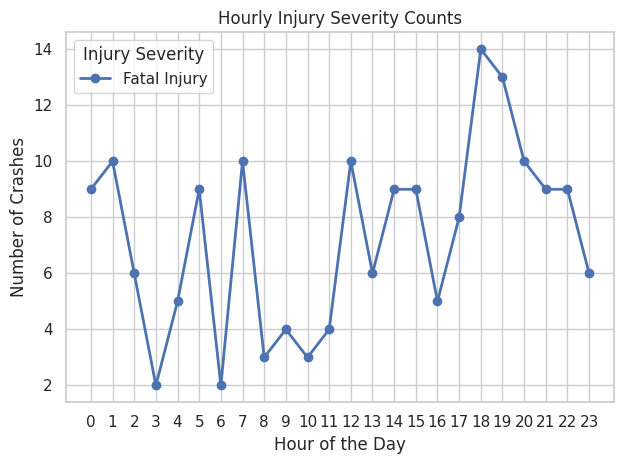

In [194]:
plt.plot(hourly_counts.index, hourly_counts['Fatal Injury'], marker='o', linewidth=2, label='Fatal Injury')

plt.title('Hourly Injury Severity Counts')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crashes')
plt.xticks(range(24))  # Set x-axis ticks for each hour
plt.legend(title='Injury Severity')
plt.tight_layout()
plt.show()

###Encoding

In [233]:
# We need different encoding for different models

# LOGISTIC REGRESSION

# One-hot encoding for nominal features
nominal_features = ['Vehicle Make', 'Driver Distracted By', 'Collision Type', 'Vehicle Body Type']
df_log = pd.get_dummies(df_log, columns=nominal_features, drop_first=True)

# Label encoding for ordinal features (if any)
ordinal_features = ['Weather', 'ACRS Report Type', 'Injury Severity', 'Surface Condition',
                    'Light', 'Driver Substance Abuse', 'Vehicle Damage Extent']

category_orders = [
    ['CLEAR', 'CLOUDY', 'WINDS','RAIN', 'WINTER WEATHER','FOG, SMOG, SMOKE', 'OTHER'],  # Weather
    ['Property Damage Crash', 'Injury Crash', 'Fatal Crash'],  # ACRS Report Type
    ['No Injury', 'Injury', 'Fatal Injury'],  # Injury Severity
    ['DRY', 'SNOW', 'WET', 'OTHER'],  # Surface Condition
    ['Afternoon', 'Morning', 'Evening', 'Night'],  # Light
    ['NONE DETECTED', 'SUBSTANCE DETECTED'],  # Substance Abuse
    ['NO DAMAGE', 'MINOR DAMAGE', 'MAJOR DAMAGE', 'DESTROYED']  # Damage Extent
]

encoder = OrdinalEncoder(categories=category_orders)
df_log[ordinal_features] = encoder.fit_transform(df_log[ordinal_features])

# Convert time features
df_log['Crash_Hour'] = pd.to_datetime(df_log['Crash Date/Time']).dt.hour
df_log['Crash_DayofWeek'] = pd.to_datetime(df_log['Crash Date/Time']).dt.dayofweek
df_log['Crash_Month'] = pd.to_datetime(df_log['Crash Date/Time']).dt.month
df_log['Crash_IsWeekend'] = df_log['Crash_DayofWeek'].isin([5, 6]).astype(int)


In [196]:
#Encoding for XGBoost and Random Forest Classifier

df_xgb = df_xgb.drop('Crash Date/Time', axis=1)
from sklearn.preprocessing import LabelEncoder

# Binary mapping
df_xgb['Injury Severity'] = df_xgb['Injury Severity'].replace({
    'No Injury': 0,
    'Injury': 1,
    'Fatal Injury': 2
})

df_xgb['Driver Substance Abuse'] = df_xgb['Driver Substance Abuse'].replace({
    'NONE DETECTED': 0,
    'SUBSTANCE DETECTED': 1
})

# Ordinal encoding
damage_order = {
    'NO DAMAGE': 0,
    'MINOR DAMAGE': 1,
    'MAJOR DAMAGE': 2,
    'DESTROYED': 3
}
df_xgb['Vehicle Damage Extent'] = df_xgb['Vehicle Damage Extent'].map(damage_order)

# One-hot encode low-cardinality features
low_card_features = [
    'Weather',
    'Surface Condition', 'Light', 'ACRS Report Type', 'Driver Distracted By',
]
df_xgb = pd.get_dummies(df_xgb, columns=low_card_features, drop_first=True)

# Label encode high-cardinality features
high_card_features = ['Vehicle Make', 'Vehicle Body Type','Collision Type']
le = LabelEncoder()
for col in high_card_features:
    df_xgb[col] = le.fit_transform(df_xgb[col])



<ipython-input-196-eddd8b927567>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_xgb['Injury Severity'] = df_xgb['Injury Severity'].replace({
<ipython-input-196-eddd8b927567>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_xgb['Driver Substance Abuse'] = df_xgb['Driver Substance Abuse'].replace({


###Clustering (for fun)

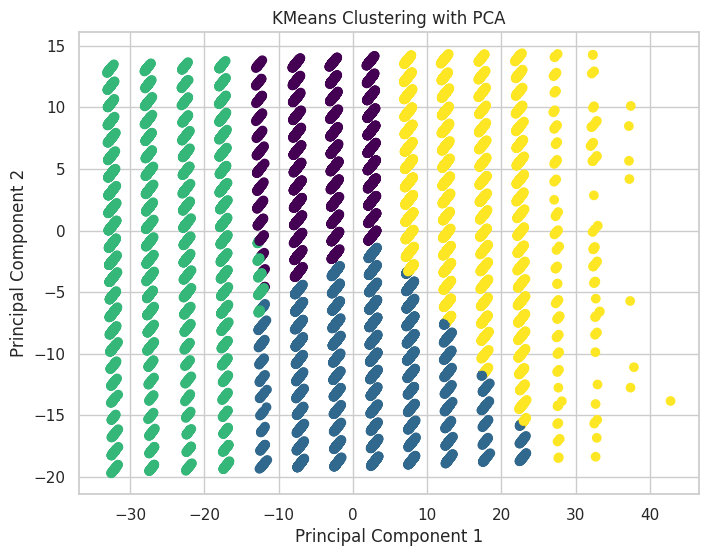

Cluster 0:
  - ACRS Report Type:
    - Mode: 0.0
    - Value Counts:
ACRS Report Type
0.0    0.646244
1.0    0.352354
2.0    0.001402
Name: proportion, dtype: float64
  - Weather:
    - Mode: 0.0
    - Value Counts:
Weather
0.0    0.766519
3.0    0.124324
1.0    0.090929
4.0    0.012191
6.0    0.003391
5.0    0.001746
2.0    0.000901
Name: proportion, dtype: float64
  - Surface Condition:
    - Mode: 0.0
    - Value Counts:
Surface Condition
0.0    0.817485
2.0    0.168121
1.0    0.010831
3.0    0.003563
Name: proportion, dtype: float64
  - Light:
    - Mode: 0.0
    - Value Counts:
Light
0.0    0.483488
2.0    0.374403
3.0    0.122035
1.0    0.020074
Name: proportion, dtype: float64
  - Driver Substance Abuse:
    - Mode: 0.0
    - Value Counts:
Driver Substance Abuse
0.0    0.968851
1.0    0.031149
Name: proportion, dtype: float64
  - Vehicle Damage Extent:
    - Mode: 1.0
    - Value Counts:
Vehicle Damage Extent
1.0    0.533696
2.0    0.373902
0.0    0.058478
3.0    0.033925
Name: 

In [225]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.utils import resample

target = 'Injury Severity'  # Replace 'Injury Severity' with your target column name
X = df_log.drop(columns=[target, 'Crash Date/Time'])
y = df_log[target]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('KMeans Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}:")
    cluster_data = X[clusters == i]  # Get data points belonging to this cluster

    for feature in X.columns:
        print(f"  - {feature}:")
        print(f"    - Mode: {cluster_data[feature].mode()[0]}")  # Get the most frequent value
        print(f"    - Value Counts:")
        print(cluster_data[feature].value_counts(normalize=True))  # Get normalized value counts

    print("\n")


###Logistic Regression Model

In [240]:
X = df_log.drop(columns=['Injury Severity', 'Crash Date/Time'])  # already encoded
y = df_log['Injury Severity']

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipeline (only numeric now)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        solver='lbfgs',
        max_iter=2000,
        class_weight='balanced',
        random_state=42
    ))
])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88     30873
         1.0       0.51      0.98      0.67      6820
         2.0       0.40      1.00      0.57        35

    accuracy                           0.83     37728
   macro avg       0.64      0.93      0.71     37728
weighted avg       0.91      0.83      0.84     37728



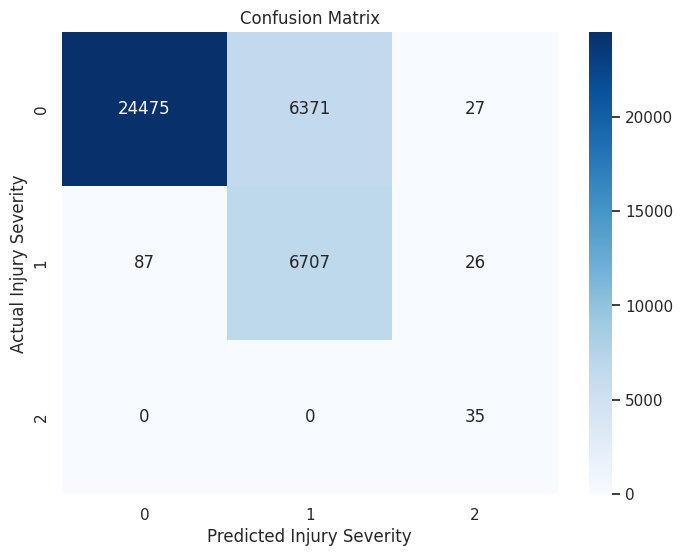

In [241]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Injury Severity")
plt.ylabel("Actual Injury Severity")
plt.title("Confusion Matrix")
plt.show()

###Random Forest Model

In [199]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

X = df_xgb.drop('Injury Severity', axis=1)
y = df_xgb['Injury Severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Parameter grid for optional tuning
param_grid = {
    'n_estimators': [100],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt']
}

# Grid search setup
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=0,
    n_jobs=-1
)

# Run only when needed
grid_search_rf.fit(X_train, y_train)

# Output best parameters (manual copy/paste below)
print("Best Parameters:")
print(grid_search_rf.best_params_)

Best Parameters:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


Training Performance
              precision    recall  f1-score   support

           0       0.93      0.93      0.93    123398
           1       0.68      0.67      0.68     27374
           2       0.96      0.74      0.84       139

    accuracy                           0.88    150911
   macro avg       0.86      0.78      0.81    150911
weighted avg       0.88      0.88      0.88    150911

Test Performance
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     30967
           1       0.66      0.66      0.66      6725
           2       0.84      0.44      0.58        36

    accuracy                           0.88     37728
   macro avg       0.81      0.68      0.72     37728
weighted avg       0.88      0.88      0.88     37728



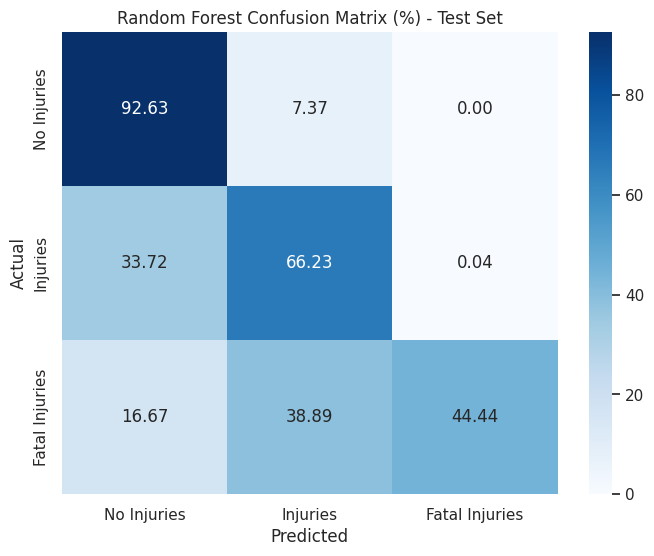

Test Accuracy: 0.8788
Test Macro F1-Score: 0.7231


In [200]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

rf_manual = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
)

rf_manual.fit(X_train, y_train)

# Predict
y_pred_train = rf_manual.predict(X_train)
y_pred_test = rf_manual.predict(X_test)

# Evaluation
print("Training Performance")
print(classification_report(y_train, y_pred_train))

print("Test Performance")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test, normalize='true')
labels = ['No Injuries', 'Injuries', 'Fatal Injuries']

plt.figure(figsize=(8, 6))
sns.heatmap(cm * 100, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix (%) - Test Set')
plt.show()

# Summary
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Test Macro F1-Score: {f1_score(y_test, y_pred_test, average='macro'):.4f}")


###XGBOOST

In [201]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define parameter grid
param_grid = {
    'max_depth': [3],
    'min_child_weight': [1],
    'colsample_bytree': [1.0],
    'subsample': [1.0],
    'reg_alpha': [1],
    'reg_lambda': [10, 20, 50, 100]
}


# Base model
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    verbosity=0,
)

# Stratified CV for multiclass balance
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    verbose=0,
    n_jobs=-1,
)

# Run grid search
grid_search.fit(X_train, y_train)

# Best params and score
print("Best Parameters:")
print(grid_search.best_params_)

print(f"Best Macro F1-Score: {grid_search.best_score_:.4f}")

Best Parameters:
{'colsample_bytree': 1.0, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 10, 'subsample': 1.0}
Best Macro F1-Score: 0.7942


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:59:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


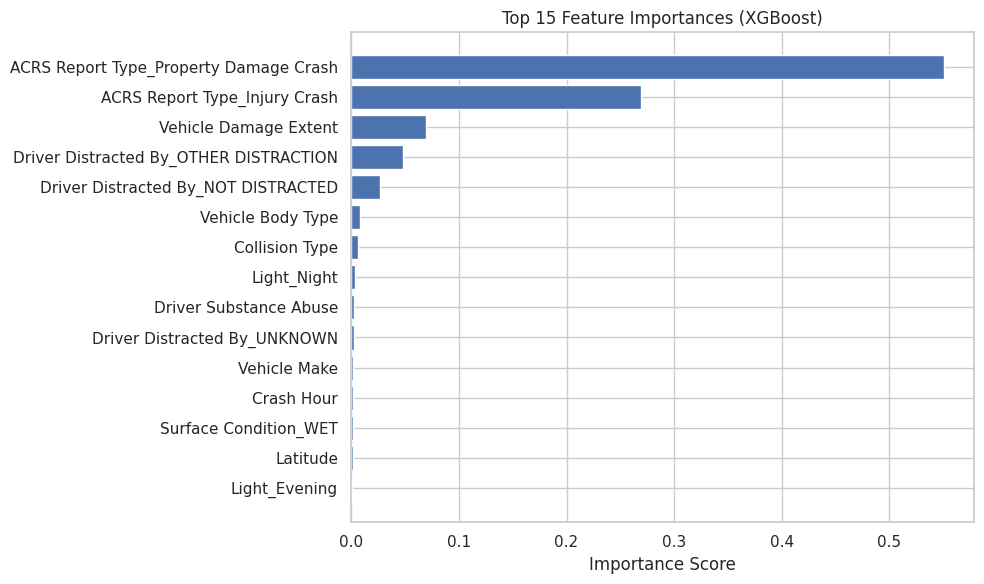

In [202]:
# Train model with regularization and subsampling
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    random_state=42,

    # Overfitting control settings:
    max_depth=3,             # shallower trees
    min_child_weight=1,      # minimum data per leaf
    subsample=1,           # row sampling
    colsample_bytree=1,    # feature sampling
    reg_alpha=1.0,           # L1 regularization
    reg_lambda=10           # L2 regularization
)

xgb.fit(X_train, y_train)

import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = xgb.feature_importances_
feature_names = X_train.columns

# Make a dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.xlabel("Importance Score")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Training Performance
              precision    recall  f1-score   support

           0       0.93      0.93      0.93    123398
           1       0.68      0.69      0.68     27374
           2       0.82      0.87      0.85       139

    accuracy                           0.88    150911
   macro avg       0.81      0.83      0.82    150911
weighted avg       0.89      0.88      0.88    150911

Test Performance
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     30967
           1       0.66      0.67      0.67      6725
           2       0.77      0.75      0.76        36

    accuracy                           0.88     37728
   macro avg       0.79      0.78      0.79     37728
weighted avg       0.88      0.88      0.88     37728



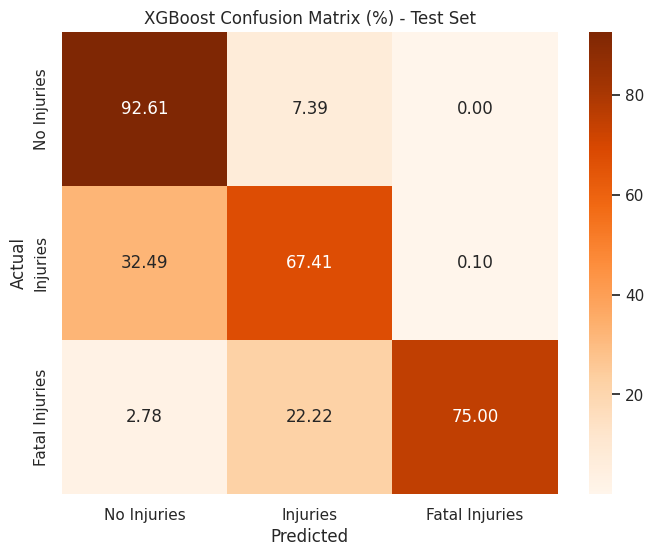

In [203]:
# Predict
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

# Evaluate
print("Training Performance")
print(classification_report(y_train, y_train_pred))

print("Test Performance")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
labels = ['No Injuries', 'Injuries', 'Fatal Injuries']

plt.figure(figsize=(8, 6))
sns.heatmap(cm * 100, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix (%) - Test Set')
plt.show()

###MLP

In [204]:
# Need to encode again with df
df_mlp = df_mlp.drop('Crash Hour', axis=1)
numerical_cols = df_mlp.select_dtypes(include=['int64', 'float64']).columns.tolist()

df_mlp = pd.get_dummies(df_mlp, columns=['ACRS Report Type'], drop_first=True)
df_mlp = pd.get_dummies(df_mlp, columns=['Collision Type'], drop_first=True)
df_mlp = pd.get_dummies(df_mlp, columns=['Weather'], drop_first=True)
#df_mlp = pd.get_dummies(df_mlp, columns=['Surface Condition'], drop_first=True)
df_mlp = pd.get_dummies(df_mlp, columns=['Light'], drop_first=True)
df_mlp = pd.get_dummies(df_mlp, columns=['Driver Substance Abuse'], drop_first=True)
df_mlp = pd.get_dummies(df_mlp, columns=['Driver Distracted By'], drop_first=True)
df_mlp = pd.get_dummies(df_mlp, columns=['Vehicle Damage Extent'], drop_first=True)
df_mlp = pd.get_dummies(df_mlp, columns=['Vehicle Body Type'], prefix='Vehicle Body Type', drop_first=True)
#df_mlp = pd.get_dummies(df_mlp, columns=['Vehicle Make'], prefix='Vehicle Make', drop_first=True)

# Extract day of the week (0 = Monday, 6 = Sunday)
#df_mlp['Crash Date/Time'] = pd.to_datetime(df_mlp['Crash Date/Time'])
#df_mlp['DayOfWeek'] = df_mlp['Crash Date/Time'].dt.dayofweek

df_mlp['Injury Severity'] = df_mlp['Injury Severity'].replace({
    'No Injury': 0,
    'Injury': 1,
    'Fatal Injury': 2
})



<ipython-input-204-db3c303ca7df>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mlp['Injury Severity'] = df_mlp['Injury Severity'].replace({


In [205]:
target = 'Injury Severity'
X = df_mlp.drop(columns=[target, 'Crash Date/Time', 'Surface Condition', 'Vehicle Make'])
y = df_mlp[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

mlp = MLPClassifier(random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 100)],
    'alpha': [0.0001, 0.001],
    'max_iter': [100, 200],
}

grid_search = GridSearchCV(
    mlp, param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=2
)

grid_search.fit(X_train, y_train)

# Best params and score
print("Best Parameters:")
print(grid_search.best_params_)

print(f"Best Macro F1-Score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters:
{'alpha': 0.0001, 'hidden_layer_sizes': (50, 100), 'max_iter': 100}
Best Macro F1-Score: 0.8783


In [206]:
from sklearn.preprocessing import StandardScaler

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

scaler = StandardScaler()
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

mlp = MLPClassifier(
    hidden_layer_sizes=(50, 100),
    activation='relu',
    solver='adam',
    max_iter=100,
    alpha=0.0001,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)


print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.93      0.91      0.92     30873
           1       0.62      0.69      0.65      6820
           2       0.70      0.80      0.75        35

    accuracy                           0.87     37728
   macro avg       0.75      0.80      0.77     37728
weighted avg       0.87      0.87      0.87     37728



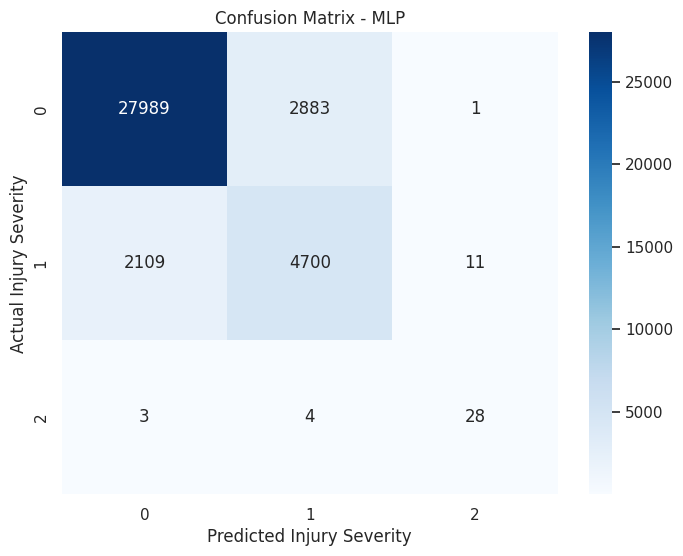

In [207]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Injury Severity")
plt.ylabel("Actual Injury Severity")
plt.title("Confusion Matrix - MLP")
plt.show()

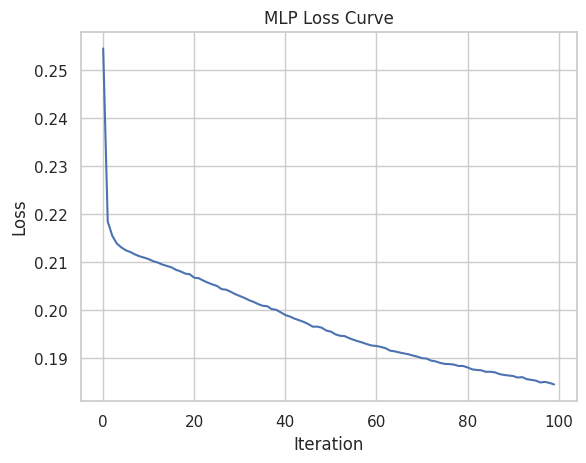

In [208]:
plt.plot(mlp.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('MLP Loss Curve')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


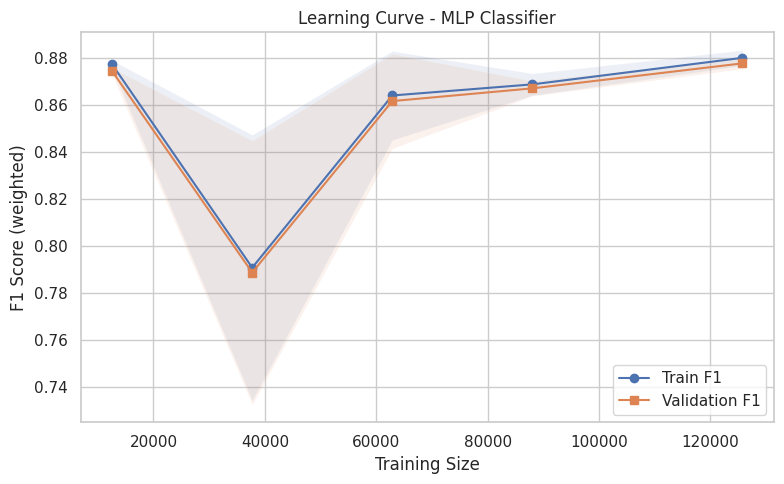

In [209]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier

# Create a fresh instance of MLP (avoid using a fitted one)
mlp = MLPClassifier(
    hidden_layer_sizes=(50, 100),
    activation='relu',
    solver='adam',
    max_iter=100,
    alpha=0.0001,
    random_state=42
)

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    mlp, X, y, cv=3, scoring='f1_weighted',
    train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],
    shuffle=True, random_state=42
)

# Compute means and stds
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Train F1', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)

plt.plot(train_sizes, val_mean, label='Validation F1', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

plt.title('Learning Curve - MLP Classifier')
plt.xlabel('Training Size')
plt.ylabel('F1 Score (weighted)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()